# Solving the n-Queens Problem using Local Search

Points: 10

## The n-Queens Problem

__Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

__State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector of length $n$, each number representing for one column (from left to write) the row the queen is located in. We will call a state a "board."

__Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).

The optimization problem is to find the optimal arrangement $a^*$ of $n$ queens on the board:

$$a^* = \mathrm{argmin}_a [ \mathrm{conflicts}(a) ]$$

$$\text{s.t.}\ a \ \text{contains only one queen per column}$$

Note that for this problem there is always an arrangement $a^*$ with $\mathrm{conflicts}(a) = 0$. 

__Local move:__ Move one queen to a different position in its column.

## Helper functions


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math


def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n-1, size = n))


def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""
    
    board = np.array(board)
    
    n = len(board)
    conflicts = 0

    # check horizontal (we do not check vertical since the state space is restricted to one queen per col)
    for i in range(n): conflicts += math.comb(np.sum(board == i), 2)
    #print(f"Horizontal conflicts: {conflicts}")
    
    # check for each queen diagonally up and down (only to the right side of the queen)
    for j in range(n):
        q_up = board[j]
        q_down = board[j]
     
        for jj in range(j+1, n):
            q_up -= 1
            q_down += 1
            if board[jj] == q_up: conflicts += 1
            if board[jj] == q_down: conflicts += 1
        #print(f"Conflicts after queen {j}: {conflicts}")
       
    return(conflicts)
        

def show_board(board, cols = ['white', 'gray']):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: 1 and j are switched. Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = 48, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts(board)} conflicts.")
    plt.show()

## Create a board

Board with 3 conflicts.


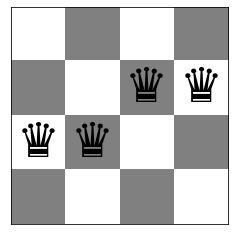

Queens (left to right) are at rows: [2 2 1 1]
Number of conflicts: 3


In [7]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


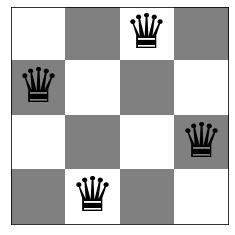

In [8]:
board = [1,3,0,2]
show_board(board)

## Steepest-ascend Hill Climbing Search [3 Points]

Calculate the objective function for all local moves (move each queen within its column) and always choose the best among all local moves.

In [78]:
import copy 
import random
from queue import PriorityQueue

def FindBest(board):                            # Find the best neighbour nearby
    bestLayout = board
    bestConflict = conflicts(bestLayout)
    
    for i in range(len(bestLayout)):
        for j in range(len(bestLayout)):                # Loop through all its neighbours
            currentLayout = copy.deepcopy(board)
            currentLayout[i] = j
            newconflict = conflicts(currentLayout)
            if(newconflict <= bestConflict):            # Here is equal so that it allows movement on the flat local maxima.
                bestLayout = currentLayout
                bestConflict = newconflict
    return bestLayout
                
    
def SAHC_Search(board, maxStep, vis):                   # Max is the maximum number of repeated steps it allowed
    current = board
    currentConflict = conflicts(current)
    UnchangedTimes = 0
    step = 0
    if(vis is True):
        print(f"Step: {step}")
        print(f"Queens (left to right) are at rows: {current}") 
        show_board(current)
        
    while(currentConflict != 0):
        step = step + 1
        newboard = FindBest(current)
        newConflicts = conflicts(newboard)
        
        if(newConflicts < currentConflict):
            if(vis is True):
                print(f"\nStep: {step}")
                print(f"Queens (left to right) are at rows: {newboard}") 
                show_board(newboard)
            UnchangedTimes = 0
        else:
            UnchangedTimes = UnchangedTimes + 1
        
        current = newboard
        currentConflict = newConflicts
        
        if(UnchangedTimes >= maxStep):                                      # If it gets stuck in the local maxima, stop the code.
            if(vis is True):
                print("Reach maximum repeat bound, but still cannot find global best")
                show_board(current)
            return (step,current)
    return (step,current)

Step: 0
Queens (left to right) are at rows: [1 0 0 0]
Board with 4 conflicts.


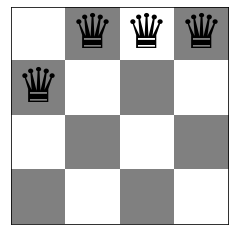


Step: 1
Queens (left to right) are at rows: [1 3 0 0]
Board with 1 conflicts.


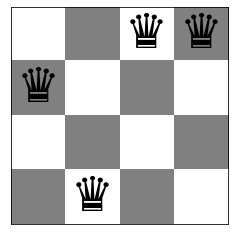


Step: 2
Queens (left to right) are at rows: [1 3 0 2]
Board with 0 conflicts.


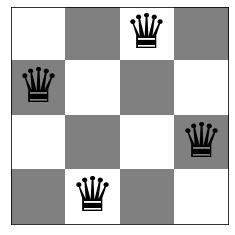

(2, array([1, 3, 0, 2]))

In [79]:
board = random_board(4)
SAHC_Search(board, 100, True)

### Steepest-ascend Hill Climbing Search Analysis
In this algorithm, the function will firstly find the best neighbour nearby, and it will choose it all the time.If it cannot find a better neighbour with smaller conflicts, it will try to find a different configuration with same conflicts. However, the problem of this algorithm is it does not have a restart function, so it will get stuck into the local minima and will be unable to jump out. Therefore, it has a maxstep to prevent infinite loop in the local minima.

## Steepest-ascend Hill Climbing Search with Random Restarts [1 Point]

Steepest-ascend hill climbing will often end up in local optima. Restart the algorithm up to 100 times with a random board to find a better (hopefully optimal) solution.   

In [97]:
def SAHC_Search_Restart(board, maxStep, maxRestart, vis):
    current = board
    currentConflict = conflicts(current)
    UnchangedTimes = 0
    step = 0
    RestartTime = 0
    
    if(vis is True):
        print(f"Step: {step}")
        print(f"Queens (left to right) are at rows: {current}") 
        print(f"Number of conflicts: {currentConflict}")
    if(vis is True):
        show_board(current)
        
    while(currentConflict != 0):
        step = step + 1
        newboard = FindBest(current)
        newConflicts = conflicts(newboard)
        
        if(newConflicts < currentConflict):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find smaller conflict")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = 0
        elif((newboard == current).all() == False):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find same conflict but different layout")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = UnchangedTimes + 1
        else:
            UnchangedTimes = UnchangedTimes + 1
        
        current = newboard
        currentConflict = newConflicts
        
        if(UnchangedTimes >= maxStep):      # If the function gets stuck in the local maxima within the 100 steps, do the restart
            RestartTime = RestartTime + 1
            if(RestartTime <= maxRestart):                
                current = random_board(len(current))                   # Reset the board
                currentConflict = conflicts(current)
                UnchangedTimes = 0
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum repeat bound, start doing restart. Restart Time: ", RestartTime)
                    print(f"Queens (left to right) are at rows: {current}") 
            else:    
                if(vis is True): # If it is still stucked in the local maxima even reach the maximum number of restart times,end the function
                    print(f"\nStep: {step}")
                    print("Reach maximum restart bound, but still cannot find global best")
                    show_board(current)
                return (step,current)
    return (step,current)

Step: 0
Queens (left to right) are at rows: [2 1 0 0]
Number of conflicts: 4
Board with 4 conflicts.


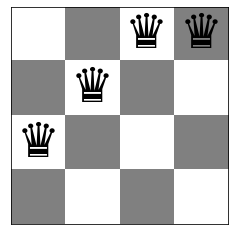


Step: 1
Find smaller conflict
Queens (left to right) are at rows: [2 1 3 0]
Number of conflicts: 1
Board with 1 conflicts.


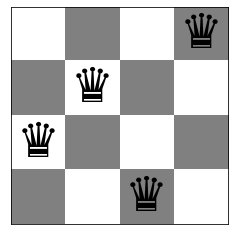


Step: 51
Reach maximum repeat bound, start doing restart. Restart Time:  1
Queens (left to right) are at rows: [0 2 1 2]

Step: 52
Find smaller conflict
Queens (left to right) are at rows: [0 3 1 2]
Number of conflicts: 1
Board with 1 conflicts.


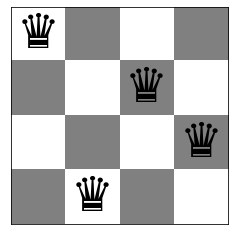


Step: 102
Reach maximum repeat bound, start doing restart. Restart Time:  2
Queens (left to right) are at rows: [0 0 0 2]

Step: 103
Find smaller conflict
Queens (left to right) are at rows: [0 3 0 2]
Number of conflicts: 1
Board with 1 conflicts.


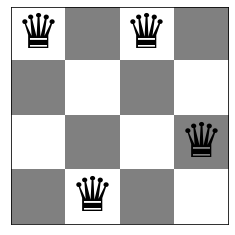


Step: 104
Find smaller conflict
Queens (left to right) are at rows: [1 3 0 2]
Number of conflicts: 0
Board with 0 conflicts.


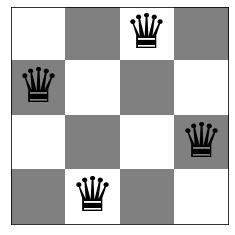

(104, array([1, 3, 0, 2]))

In [98]:
board = random_board(4)
SAHC_Search_Restart(board, 50, 20, True)

### Steepest-ascend Hill Climbing Search with Random Restarts analysis
Differently from the first algorithm, this algorithm has a random restart function to jump out of the local minima. If the function gets stuck in the local minima in a number of steps, it will randomly reset the board and keep searching. However, even add a random restart still does not guarantee to find the global minima, so it also has a bound of maximum number of restart; if the function hits that bound, the function will end. Since those two bounds are both the parameters of this function, changing those may affect the performace of this algorithm. For example, if the bound of repeated steps is too big, it will waste many time on the local minima. Besides, this algorithm also allows movements on the flat local minima, so it will be more easier to get the goal.

## Stochastic Hill Climbing [1 Point]

Chooses randomly from among all uphill moves.

In [99]:
def FindRandom(board):                      # Randomly choose a neighbour 
    Total = []
    TotalFlate = []
    oldconflict = conflicts(board)
    for i in range(len(board)):
        for j in range(len(board)):
            if(j != board[i]):
                currentLayout = copy.deepcopy(board)
                currentLayout[i] = j
                if(conflicts(currentLayout) < oldconflict):
                    Total.append(currentLayout)
                elif(conflicts(currentLayout) == oldconflict):  # If no better option, use the random neighbour on the flat local maxima
                    TotalFlate.append(currentLayout)
    if(len(Total) != 0):
        return random.choice(Total)
    elif(len(TotalFlate) != 0):
        return random.choice(TotalFlate)
    else:
        return board


def SHC_Search(board, maxStep, maxRestart, vis):
    current = board
    currentConflict = conflicts(current)
    UnchangedTimes = 0
    step = 0
    RestartTime = 0
    
    if(vis is True):
        print(f"Step: {step}")
        print(f"Queens (left to right) are at rows: {current}") 
        print(f"Number of conflicts: {currentConflict}")
    if(vis is True):
        show_board(current)
        
    while(currentConflict != 0):
        step = step + 1
        newboard = FindRandom(current)
        newConflicts = conflicts(newboard)
        
        if(newConflicts < currentConflict):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find smaller conflict")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = 0
        elif((newboard == current).all() == False):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find same conflict but different layout")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = UnchangedTimes + 1
        else:
            UnchangedTimes = UnchangedTimes + 1
        
        current = newboard
        currentConflict = newConflicts
        
        if(UnchangedTimes >= maxStep):
            RestartTime = RestartTime + 1
            if(RestartTime <= maxRestart):
                current = random_board(len(current))
                currentConflict = conflicts(current)
                UnchangedTimes = 0
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum repeat bound, start doing restart. Restart Time: ", RestartTime)
                    print(f"Queens (left to right) are at rows: {current}") 
            else:
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum restart bound, but still cannot find global best")
                    show_board(current)
                return (step,current)
    return (step,current)

Step: 0
Queens (left to right) are at rows: [1 2 1 2]
Number of conflicts: 5
Board with 5 conflicts.


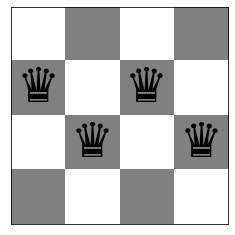


Step: 1
Find smaller conflict
Queens (left to right) are at rows: [1 2 2 2]
Number of conflicts: 4
Board with 4 conflicts.


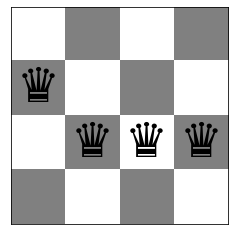


Step: 2
Find smaller conflict
Queens (left to right) are at rows: [1 2 2 0]
Number of conflicts: 3
Board with 3 conflicts.


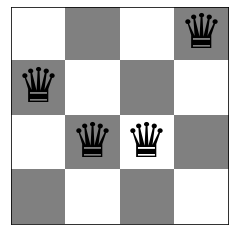


Step: 3
Find smaller conflict
Queens (left to right) are at rows: [1 1 2 0]
Number of conflicts: 2
Board with 2 conflicts.


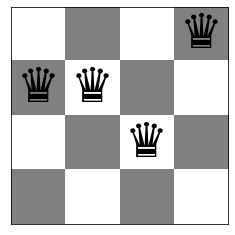


Step: 4
Find smaller conflict
Queens (left to right) are at rows: [1 3 2 0]
Number of conflicts: 1
Board with 1 conflicts.


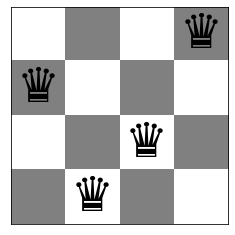


Step: 5
Find same conflict but different layout
Queens (left to right) are at rows: [1 3 0 0]
Number of conflicts: 1
Board with 1 conflicts.


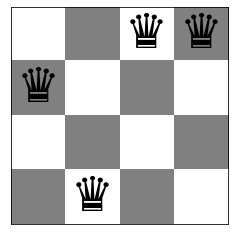


Step: 6
Find smaller conflict
Queens (left to right) are at rows: [1 3 0 2]
Number of conflicts: 0
Board with 0 conflicts.


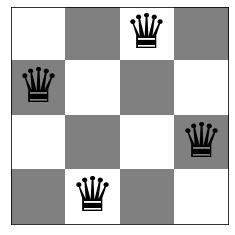

(6, array([1, 3, 0, 2]))

In [100]:
board = random_board(4)
SHC_Search(board, 50, 20, True)

### Stochastic Hill Climbing Analysis
This algorithm is similar to the Steepest-ascend Hill Climbing Search with Random Restarts, but instead of choosing the best neighbour, it will randomly choose one from the neighbourhood list. This algorithm could be better in some cases when there is a local minima nearby; the steepest-ascend hill climbing will direct go to the local minima, while the stochastic hill climbing may have a chance to aviod that local minima. However, this algorithm, with randomly choosing, could be worse if there is the global minima nearby, the algorithm may be hard to find that peak.

## First-choice Hill Climbing [1 Point]

First-choice hill climbing is a type of stochastic hill climbing that generates one random local neighbor at a time and accept it if it has a better objective function value than the current state.

In [101]:
def FindFirst(board):                   # Find the first better neighbour it met.
    FirstFlate = board
    oldconflict = conflicts(board)
    for i in range(len(board)):
        for j in range(len(board)):
            if(j != board[i]):
                currentLayout = copy.deepcopy(board)
                currentLayout[i] = j
                if(conflicts(currentLayout) < oldconflict):
                    return currentLayout                        # Return that best neighbour 
                elif(conflicts(currentLayout) == oldconflict and (FirstFlate == board).all() == True ):
                    FirstFlate = currentLayout                  # Record the first neighbour with same conflicts but different layout
    return FirstFlate                                           # If there is no better neighbour, it will return that


def FCHC_Search(board, maxStep, maxRestart, vis):
    current = board
    currentConflict = conflicts(current)
    UnchangedTimes = 0
    step = 0
    RestartTime = 0
    
    if(vis is True):
        print(f"Step: {step}")
        print(f"Queens (left to right) are at rows: {current}") 
        print(f"Number of conflicts: {currentConflict}")
        show_board(current)
        
    while(currentConflict != 0):
        step = step + 1
        newboard = FindFirst(current)
        newConflicts = conflicts(newboard)
        
        if(newConflicts < currentConflict):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find smaller conflict")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = 0
        elif((newboard == current).all() == False):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find same conflict but different layout")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = UnchangedTimes + 1
        else:
            UnchangedTimes = UnchangedTimes + 1
        
        current = newboard
        currentConflict = newConflicts
        
        if(UnchangedTimes >= maxStep):
            RestartTime = RestartTime + 1
            if(RestartTime <= maxRestart):
                current = random_board(len(current))
                currentConflict = conflicts(current)
                UnchangedTimes = 0
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum repeat bound, start doing restart. Restart Time: ", RestartTime)
                    print(f"Queens (left to right) are at rows: {current}") 
            else:
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum restart bound, but still cannot find global best")
                    show_board(current)
                return (step,current)
    return (step,current)

Step: 0
Queens (left to right) are at rows: [1 0 1 1]
Number of conflicts: 5
Board with 5 conflicts.


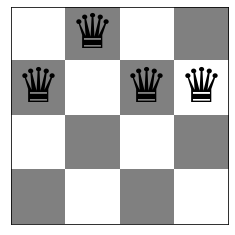


Step: 1
Find smaller conflict
Queens (left to right) are at rows: [0 0 1 1]
Number of conflicts: 3
Board with 3 conflicts.


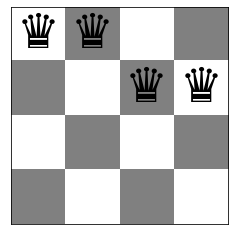


Step: 2
Find smaller conflict
Queens (left to right) are at rows: [2 0 1 1]
Number of conflicts: 2
Board with 2 conflicts.


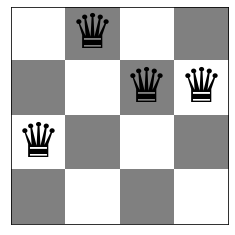


Step: 3
Find smaller conflict
Queens (left to right) are at rows: [2 0 3 1]
Number of conflicts: 0
Board with 0 conflicts.


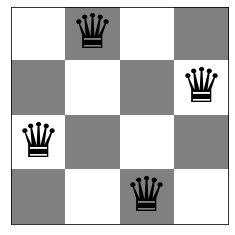

(3, array([2, 0, 3, 1]))

In [102]:
board = random_board(4)
FCHC_Search(board, 100, 100, True)

### First-choice Hill Climbing analysis
Instead of randomly choosing one from all the neighbourhoods, it will choose the first neighbour it found. Therefore, First-Choice Hill Climbing will become a slightly better strategy if the current state has a lot of neighbors, in this case it depends on the board size, since it will take shorter time to find all the neighbours. 

## Simulated Annealing [2 Points]

You have to experiment with the annealing schedule.

In [105]:
from math import e

def Find_Child(board, T):
    Total = []                      
    oldconflict = conflicts(board)          
    for i in range(len(board)):                     # Find all the options
        for j in range(len(board)):
            if(j != board[i]):
                currentLayout = copy.deepcopy(board)
                currentLayout[i] = j
                Total.append(currentLayout)
    
    newlayout = random.choice(Total)
    if(conflicts(newlayout) <= oldconflict):       # If the new layout has fewer conflicts
        return newlayout
    else:
        p = e**( -(conflicts(newlayout) - oldconflict) / T)    # It is the Simulated Annealing formula
        select = random.randint(0,100000)         # Here is 100000 to make accuracy millionths decimal place 
        if(select < p*100000 and p >= (1 * e**-6)):   # At some of the possibility, accept bad moves
            return newlayout
        else:
            return board
    

def SA_Search(board, maxStep, maxRestart, vis):
    current = board
    currentConflict = conflicts(current)
    UnchangedTimes = 0
    step = 0
    RestartTime = 0
    
    if(vis is True):
        print(f"Step: {step}")
        print(f"Queens (left to right) are at rows: {current}") 
        print(f"Number of conflicts: {currentConflict}")
        show_board(current)
        
    while(currentConflict != 0):
        step = step + 1             
        newboard = Find_Child(current, 50 * (0.9 ** step)) # The Cooling Schedule formula
        newConflicts = conflicts(newboard) # Alpha is 0.9, T0 is 50 so that the initial probability is around 0.9    
        
        if(newConflicts < currentConflict):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Find smaller conflict")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = 0
        elif(newConflicts > currentConflict):
            if(vis is True):
                print(f"\nStep: {step}")
                print("Try to accept worse case")
                print(f"Queens (left to right) are at rows: {newboard}") 
                print(f"Number of conflicts: {newConflicts}")
                show_board(newboard)
            UnchangedTimes = UnchangedTimes + 1
        else:
            UnchangedTimes = UnchangedTimes + 1
        
        current = newboard
        currentConflict = newConflicts
        
        if(UnchangedTimes >= maxStep):
            RestartTime = RestartTime + 1
            if(RestartTime <= maxRestart):
                current = random_board(len(current))
                currentConflict = conflicts(current)
                UnchangedTimes = 0
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum repeat bound, start doing restart. Restart Time: ", RestartTime)
                    print(f"Queens (left to right) are at rows: {current}") 
            else:
                if(vis is True):
                    print(f"\nStep: {step}")
                    print("Reach maximum restart bound, but still cannot find global best")
                    show_board(current)
                return (step,current)
    return (step,current)

Step: 0
Queens (left to right) are at rows: [1 2 1 1]
Number of conflicts: 5
Board with 5 conflicts.


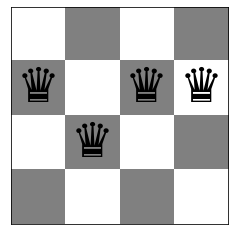


Step: 1
Find smaller conflict
Queens (left to right) are at rows: [1 3 1 1]
Number of conflicts: 4
Board with 4 conflicts.


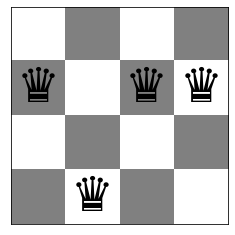


Step: 2
Try to accept worse case
Queens (left to right) are at rows: [1 0 1 1]
Number of conflicts: 5
Board with 5 conflicts.


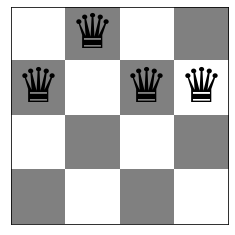


Step: 3
Find smaller conflict
Queens (left to right) are at rows: [2 0 1 1]
Number of conflicts: 2
Board with 2 conflicts.


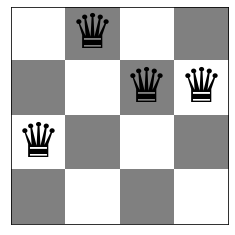


Step: 4
Try to accept worse case
Queens (left to right) are at rows: [2 3 1 1]
Number of conflicts: 3
Board with 3 conflicts.


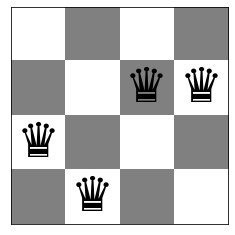


Step: 5
Try to accept worse case
Queens (left to right) are at rows: [2 3 0 1]
Number of conflicts: 4
Board with 4 conflicts.


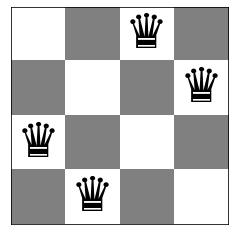


Step: 6
Try to accept worse case
Queens (left to right) are at rows: [2 1 0 1]
Number of conflicts: 5
Board with 5 conflicts.


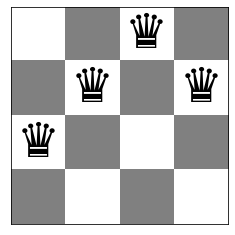


Step: 7
Find smaller conflict
Queens (left to right) are at rows: [2 3 0 1]
Number of conflicts: 4
Board with 4 conflicts.


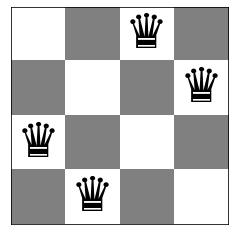


Step: 8
Find smaller conflict
Queens (left to right) are at rows: [2 3 3 1]
Number of conflicts: 3
Board with 3 conflicts.


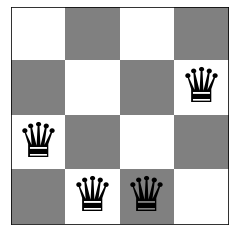


Step: 11
Find smaller conflict
Queens (left to right) are at rows: [0 3 1 2]
Number of conflicts: 1
Board with 1 conflicts.


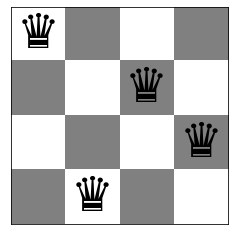


Step: 12
Try to accept worse case
Queens (left to right) are at rows: [0 3 2 2]
Number of conflicts: 3
Board with 3 conflicts.


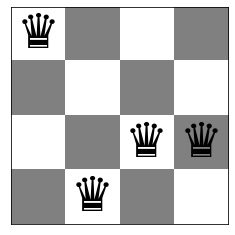


Step: 13
Try to accept worse case
Queens (left to right) are at rows: [2 3 2 2]
Number of conflicts: 5
Board with 5 conflicts.


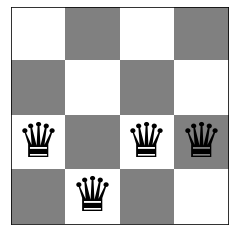


Step: 15
Find smaller conflict
Queens (left to right) are at rows: [3 1 2 2]
Number of conflicts: 2
Board with 2 conflicts.


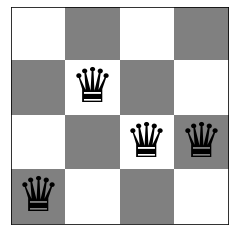


Step: 16
Find smaller conflict
Queens (left to right) are at rows: [3 1 0 2]
Number of conflicts: 1
Board with 1 conflicts.


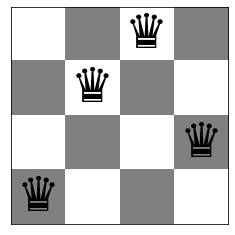


Step: 17
Try to accept worse case
Queens (left to right) are at rows: [3 1 0 1]
Number of conflicts: 3
Board with 3 conflicts.


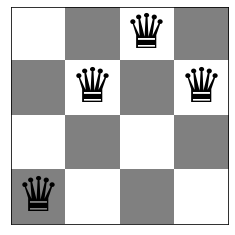


Step: 20
Try to accept worse case
Queens (left to right) are at rows: [2 2 2 1]
Number of conflicts: 4
Board with 4 conflicts.


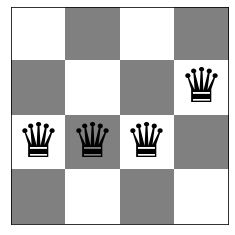


Step: 21
Find smaller conflict
Queens (left to right) are at rows: [3 2 2 1]
Number of conflicts: 3
Board with 3 conflicts.


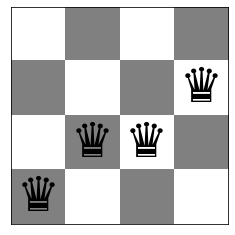


Step: 22
Try to accept worse case
Queens (left to right) are at rows: [3 2 2 3]
Number of conflicts: 4
Board with 4 conflicts.


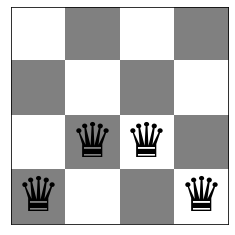


Step: 24
Find smaller conflict
Queens (left to right) are at rows: [2 2 0 3]
Number of conflicts: 2
Board with 2 conflicts.


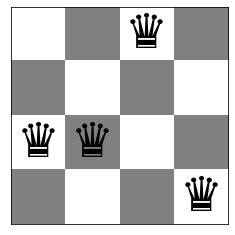


Step: 28
Try to accept worse case
Queens (left to right) are at rows: [2 0 0 0]
Number of conflicts: 4
Board with 4 conflicts.


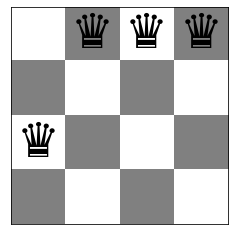


Step: 30
Find smaller conflict
Queens (left to right) are at rows: [2 0 1 0]
Number of conflicts: 3
Board with 3 conflicts.


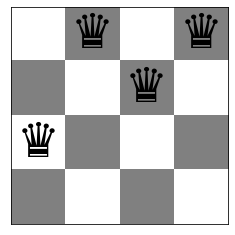


Step: 31
Try to accept worse case
Queens (left to right) are at rows: [2 2 1 0]
Number of conflicts: 4
Board with 4 conflicts.


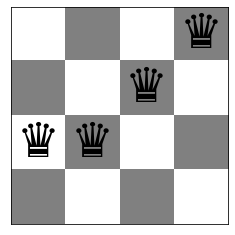


Step: 32
Find smaller conflict
Queens (left to right) are at rows: [2 3 1 0]
Number of conflicts: 2
Board with 2 conflicts.


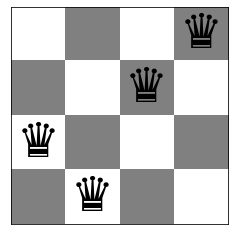


Step: 38
Try to accept worse case
Queens (left to right) are at rows: [2 3 2 0]
Number of conflicts: 3
Board with 3 conflicts.


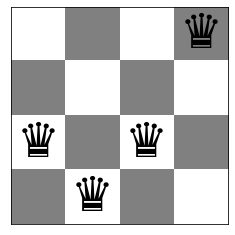


Step: 39
Find smaller conflict
Queens (left to right) are at rows: [1 3 2 0]
Number of conflicts: 1
Board with 1 conflicts.


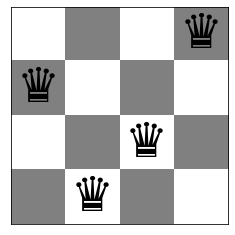


Step: 48
Find smaller conflict
Queens (left to right) are at rows: [1 3 0 2]
Number of conflicts: 0
Board with 0 conflicts.


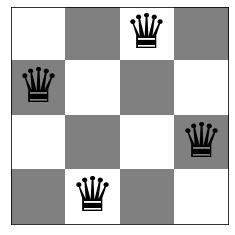

(48, array([1, 3, 0, 2]))

In [109]:
board = random_board(4)
SA_Search(board, 50, 20, True)

### Simulated Annealing analysis
The Simulated Annealing I implemented is similar to the Stochastic Hill Climbing. However, instead of choosing better result, it has a posibillity to choose the worse case. In this case, I use the formula p = e^-(deltaE/T), where deltaE is the difference between two configuration's conflicts; T is the temperature, and here I use the Cooling Schedule formula: T_k =  T_0 * alpha ^ k where k is the step, alpha is 0.9, and T0 I set is 50. I set T0 to 50 so that based on the formula the initial probability will be around 0.9. 

## Compare Performance [2 Points]

Use runtime, scalability, and best objective function value to compare the algorithms on boards of different sizes.  

For timing you can use the `time` package.

In [110]:
import time
import matplotlib.pyplot as plt

def Analysis():
    SAHC_Step = []
    SAHC_Time = []
    SAHCR_Step = []
    SAHCR_Time = []
    SHC_Step = []
    SHC_Time = []
    FCHC_Step = []
    FCHC_Time = []
    SA_Step = []
    SA_Time = []
    X_axis = [4,5,6,7,8]
    
    for i in range(5):
        SAHC_totalTime = 0
        SAHC_totalStep = 0
        SAHCR_totalStep = 0
        SAHCR_totalTime = 0
        SHC_totalStep = 0
        SHC_totalTime = 0
        FCHC_totalStep = 0
        FCHC_totalTime = 0
        SA_totalStep = 0
        SA_totalTime = 0
        
        for j in range(50):
            
            t0 = time.time()
            board = random_board(i+4)
            Result1 = SAHC_Search(board, 1000, False)
            t1 = time.time()
            SAHC_totalTime = SAHC_totalTime + ((t1-t0) * 1e3)
            SAHC_totalStep = SAHC_totalStep + Result1[0]
            
            t0 = time.time()
            board = random_board(i+4)
            Result2 = SAHC_Search_Restart(board, 50, 20, False)
            t1 = time.time()
            SAHCR_totalTime = SAHCR_totalTime + ((t1-t0) * 1e3)
            SAHCR_totalStep = SAHCR_totalStep + Result2[0]
            
            t0 = time.time()
            board = random_board(i+4)
            Result3 = SHC_Search(board, 50, 20, False)
            t1 = time.time()
            SHC_totalTime = SHC_totalTime + ((t1-t0) * 1e3)
            SHC_totalStep = SHC_totalStep + Result3[0]
            
            t0 = time.time()
            board = random_board(i+4)
            Result4 = FCHC_Search(board, 50, 20, False)
            t1 = time.time()
            FCHC_totalTime = FCHC_totalTime + ((t1-t0) * 1e3)
            FCHC_totalStep = FCHC_totalStep + Result4[0]
        
            t0 = time.time()
            board = random_board(i+4)
            Result5 = SA_Search(board, 50, 20, False)
            t1 = time.time()
            SA_totalTime = SA_totalTime + ((t1-t0) * 1e3)
            SA_totalStep = SA_totalStep + Result5[0]
     
        SAHC_totalTime = SAHC_totalTime / 50
        SAHC_totalStep = SAHC_totalStep / 50
        SAHCR_totalTime = SAHCR_totalTime / 50
        SAHCR_totalStep = SAHCR_totalStep / 50
        SHC_totalTime = SHC_totalTime / 50
        SHC_totalStep = SHC_totalStep / 50
        FCHC_totalTime = FCHC_totalTime / 50
        FCHC_totalStep = FCHC_totalStep / 50
        SA_totalTime = SA_totalTime / 50
        SA_totalStep = SA_totalStep / 50
        
        SAHC_Step.append(SAHC_totalStep)
        SAHC_Time.append(SAHC_totalTime)
        SAHCR_Step.append(SAHCR_totalStep)
        SAHCR_Time.append(SAHCR_totalTime)
        SHC_Step.append(SHC_totalStep)
        SHC_Time.append(SHC_totalTime)
        FCHC_Step.append(FCHC_totalStep)
        FCHC_Time.append(FCHC_totalTime)
        SA_Step.append(SA_totalStep)
        SA_Time.append(SA_totalTime)
        
        
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(X_axis, SAHC_Step, 'r-' , label = 'SAHC_Step')
    ax.plot(X_axis, SAHCR_Step, 'b-' , label = 'SAHCR_Step')
    ax.plot(X_axis, SHC_Step, 'g-' , label = 'SHC_Step')
    ax.plot(X_axis, FCHC_Step, 'y-' , label = 'FCHC_Step')
    ax.plot(X_axis, SA_Step, 'c-' , label = 'SA_Step')
    leg = ax.legend()
    plt.title("Average steps for each algorithm with different size")
    plt.xlabel("Board Length")
    plt.ylabel("Average Steps")
    
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(1,1,1)
    ax1.plot(X_axis, SAHC_Time, 'r-' , label = 'SAHC_Time')
    ax1.plot(X_axis, SAHCR_Time, 'b-' , label = 'SAHCR_Time')
    ax1.plot(X_axis, SHC_Time, 'g-' , label = 'SHC_Time')
    ax1.plot(X_axis, FCHC_Time, 'y-' , label = 'FCHC_Time')
    ax1.plot(X_axis, SA_Time, 'c-' , label = 'SA_Time')
    leg = ax1.legend()
    plt.title("Average time for each algorithm with different size")
    plt.xlabel("Board Length")
    plt.ylabel("Average Time (milliseconds)")
    
    plt.show()

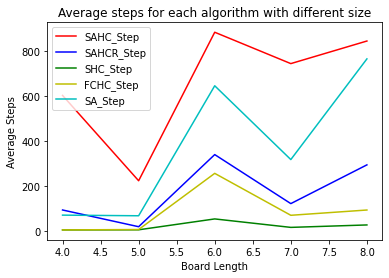

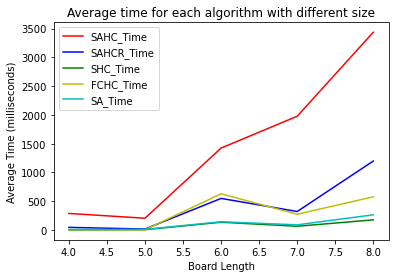

In [111]:
Analysis()

### Comparisons betweeen algorithms
* I test all five algorithms, run them 50 times for each one with different board size.
#### The first comparison I made is base on the steps, not conflicts, since most of the algorithms I implemented have random-restart, so they have the capacity to find the 0-conflict configuration. 
* The algorithm in the top of the graph is the Steepest-ascend Hill Climbing Search; that's because it does not have a random-restart function, so it will easily get stuck in the local minima, reach the maximum step bound, and end. Since the maximum steps I defined is 1000 for this function, it also proves that the algorthm is in the local minima.
* The second algorithm is the Simulated Annealing, that's because the function will randomly select a successor from all the neighbours, and it will only make a change if 1: it finds a smaller conflict 2: it finds the worse case but the possibility allows that movement. Therefore, it will waste a lot of steps on either hold the position until restart or escape local minima but to a wrong direction.
* The rests are relatively close, Steepest-ascend Hill Climbing Search with randomly restart takes a few more steps because there are many local minima in the problem. Besides, Stochastic Hill Climbing takes the fewest step mainly because in the n-queens problem the number of neighbour is not that huge, so First-choice Hill Climbing may not have much benefit compared to the SHC.
#### The second comparison is base on the time
* Steepest-ascend Hill Climbing Search is also the worst on since it put nealy all its time in the local minima. 
* The other four algorithms are close, sicne their implementations are similar, and the only difference is how to choose the successor.

## Bonus: Genetic Algorithm [+1 Point]

In [114]:
def Insert_List(Geneticlist, board, max):               # Insert an item into the genetic list
    for j in range(len(Geneticlist)):
        if((Geneticlist[j] == board).all()):            # If exist
            return
        
    newconflict = conflicts(board)
    for k in range(len(Geneticlist)):                   # Insert based on the conflicts, make sure the list is always sorted
        if(newconflict <= conflicts(Geneticlist[k])):
            Geneticlist.insert(k, board)
            if(len(Geneticlist) > max):                # Make sure the list does not exceed the maximum size
                Geneticlist.pop()
            return
    Geneticlist.append(board)
    if(len(Geneticlist) > max):
        Geneticlist.pop()
    return 
    
        
def CrossOver(Parent1, Parent2):
    Child1 = copy.deepcopy(Parent1)
    Child2 = copy.deepcopy(Parent2)
    SinglePoint = random.randint(1,len(Child1)-2)           # Randomly choose the single crossover point
    for i in range(SinglePoint):
        temp = Child1[i]
        Child1[i] = Child2[i]                               # Make two children based on the rotation around the single point
        Child2[i] = temp
    return [Child1, Child2]
    
    
def Mutation(Children, p):
    for Child in Children:
        result = random.randint(1,100)
        if(result <= p*100):   # Evoke muatation based on the possibility, if mutations happens, a random queen will move to a random column
            loc = random.randint(0,len(Child)-1)
            newnumber = random.randint(0,len(Child)-1)
            Child[loc] = newnumber

def GA_Search(boardSize, ListSize, maxStep, p, vis):
    Geneticlist = []
    while(len(Geneticlist) < ListSize):
        Insert_List(Geneticlist, random_board(boardSize), ListSize)     # Initialize the genetic list
    
    step = 0
    bestConflict = conflicts(Geneticlist[0])
    
    if(vis == True):
        print(f"\nStep: {step}")
        print("Find Initial configuration")
        print(f"Queens (left to right) are at rows: {Geneticlist[0]}") 
        print(f"Number of conflicts: {bestConflict}")
        show_board(Geneticlist[0])
    
    
    while(step < maxStep):
        step = step + 1
        Parent1 = copy.deepcopy(Geneticlist[0])# Choose two parents from the top of the list. (better parents may bring better children)
        Parent2 = copy.deepcopy(Geneticlist[1])
        
        if(conflicts(Parent1) == 0):                        # If parents are global maxima
            if(vis == True):
                print(f"\nStep: {step}")
                print("Find 0 conflict configuration")
                print(f"Queens (left to right) are at rows: {Parent1}") 
                print(f"Number of conflicts: {conflicts(Parent1)}")
                show_board(Parent1)
            return (step,Parent1)
        
        if(conflicts(Parent2) == 0):
            if(vis == True):
                print(f"\nStep: {step}")
                print("Find 0 conflict configuration")
                print(f"Queens (left to right) are at rows: {Parent2}") 
                print(f"Number of conflicts: {conflicts(Parent2)}")
                show_board(Parent2)
            return (step,Parent2)
        
        
        Children = CrossOver(Parent1, Parent2)                  # Doing crossover to create two children
        
        if(conflicts(Children[0]) == 0):                        # If children are global maxima
            if(vis == True):
                print(f"\nStep: {step}")
                print("Find 0 conflict configuration")
                print(f"Queens (left to right) are at rows: {Children[0]}") 
                print(f"Number of conflicts: {conflicts(Children[0])}")
                show_board(Children[0])
            return (step,Children[0])
        elif(conflicts(Children[0]) < bestConflict and vis == True):
            print(f"\nStep: {step}")
            print("Find smaller conflict configuration")
            print(f"Queens (left to right) are at rows: {Children[0]}") 
            print(f"Number of conflicts: {conflicts(Children[0])}")
            show_board(Children[0])
            bestConflict = conflicts(Children[0])               # Update the smallest conflict it found
            
        if(conflicts(Children[1]) == 0):
            if(vis == True):
                print(f"\nStep: {step}")
                print("Find 0 conflict configuration")
                print(f"Queens (left to right) are at rows: {Children[1]}") 
                print(f"Number of conflicts: {conflicts(Children[1])}")
                show_board(Children[1])
            return (step, Children[1])
        elif(conflicts(Children[1]) < bestConflict and vis == True):
            print(f"\nStep: {step}")
            print("Find smaller conflict configuration")
            print(f"Queens (left to right) are at rows: {Children[1]}") 
            print(f"Number of conflicts: {conflicts(Children[1])}")
            show_board(Children[1])
            bestConflict = conflicts(Children[1])
        

        Mutation(Children, p)                            # Doing mutation based on possibility p       
        
        if(conflicts(Children[0]) == 0):                # Check if new children are global maxima
            if(vis == True):
                print(f"\nStep: {step}")
                print("Find 0 conflict configuration")
                print(f"Queens (left to right) are at rows: {Children[0]}") 
                print(f"Number of conflicts: {conflicts(Children[0])}")
                show_board(Children[0])
            return (step,Children[0])
        elif(conflicts(Children[0]) < bestConflict and vis == True):
            print(f"\nStep: {step}")
            print("Find smaller conflict configuration")
            print(f"Queens (left to right) are at rows: {Children[0]}") 
            print(f"Number of conflicts: {conflicts(Children[0])}")
            show_board(Children[0])
            bestConflict = conflicts(Children[0])
        
        if(conflicts(Children[1]) == 0):
            if(vis == True):
                print(f"\nStep: {step}")
                print("Find 0 conflict configuration")
                print(f"Queens (left to right) are at rows: {Children[1]}") 
                print(f"Number of conflicts: {conflicts(Children[1])}")
                show_board(Children[1])
            return ( step, Children[1])
        elif(conflicts(Children[1]) < bestConflict and vis == True):
            print(f"\nStep: {step}")
            print("Find smaller conflict configuration")
            print(f"Queens (left to right) are at rows: {Children[1]}") 
            print(f"Number of conflicts: {conflicts(Children[1])}")
            show_board(Children[1])
            bestConflict = conflicts(Children[1])
        
        for Child in Children:                          # Put those two children into the list
            Insert_List(Geneticlist,Child, ListSize)
    
    print("Reach maximum repeat bound, but still cannot find global best")
    return (step, Geneticlist[0])                            # If cannot find global maxima, use the cloest one 


Step: 0
Find Initial configuration
Queens (left to right) are at rows: [1 0 2 2]
Number of conflicts: 3
Board with 3 conflicts.


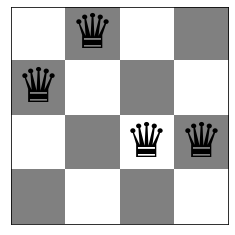


Step: 2
Find smaller conflict configuration
Queens (left to right) are at rows: [1 3 2 2]
Number of conflicts: 2
Board with 2 conflicts.


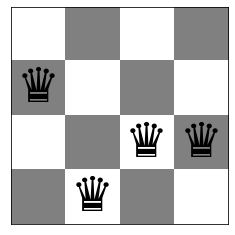


Step: 28
Find 0 conflict configuration
Queens (left to right) are at rows: [1 3 0 2]
Number of conflicts: 0
Board with 0 conflicts.


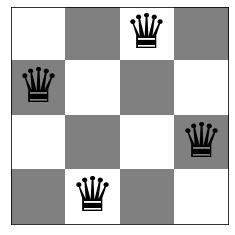

(28, array([1, 3, 0, 2]))

In [115]:
GA_Search(4, 10, 1000, 0.15, True) # Board size, genetic list size (max number of species in one round), max number of rounds, possibility of mutation 

### Genetic Algorithm analysis 
The function has 5 parameters: board length, maximum size of species in each round, the maximum number of rounds, the posibillity of mutation in each round, and the visibility of the code run. The algorithm has threes steps in each generation round: selection, crossover, and mutation.
* Initialize the generation list: At the beginning, randomly create a list of species, sorted by its performace; in this case it is the conlicts from small to large
* Selection: In each round, it will select the best parents in the group, so they are the top-two on the list.
* Crossover: This algorithm uses the Single-Point Crossover, so it will randomly create a crossover point from the parents, switch their left and right sides.
* Mutation: The two children have a possibily to mutate, and the mutation will randomly choose a place on the child, mutate to a random number.